In [1]:
import sys
sys.path.append('../')
# print (sys.path)
import torch
import logging
import unittest
import traceback
import numpy as np

from castle.algorithms import *
from castle.common import consts
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

from utils.functional import combined_params

2023-03-16 17:52:14,820 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-03-16 17:52:14,854 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


## load data & params

In [2]:
data = np.load('dataset/linear_gauss_6nodes_15edges.npz', allow_pickle=True)
x = data['x']
true_dag = data['y']
rank = np.linalg.matrix_rank(true_dag)
error_params = []

In [3]:
def add_params(params=None) -> dict:
    """
    add parameter `device_type` for algorithms based on torch

    Parameters
    ----------
    params: dict
        from castle.common.consts
    """

    if params is None:
        params = dict()
    if torch.cuda.is_available():
        params['device_type'] = ['cpu', 'gpu']
    else:
        params['device_type'] = ['cpu']

    return params

## test

In [4]:
results = []

In [6]:
anm = ANMNonlinear(alpha=0.05)
anm.learn(data=x)

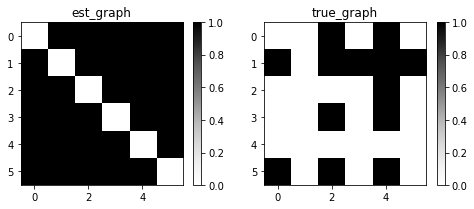

{'fdr': 0.1333, 'tpr': 1.0, 'fpr': 1.0, 'shd': 2, 'nnz': 15, 'precision': 0.4333, 'recall': 1.0, 'F1': 0.6047, 'gscore': 0.0}


In [7]:
GraphDAG(anm.causal_matrix, true_dag)
mm = MetricsDAG(anm.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm.metrics)

In [8]:
p_corl = add_params(consts.CORL_VALID_PARAMS)

In [9]:
for d in combined_params(p_corl):
    try:
        algo = CORL(**d, iteration=3)
        algo.learn(data=x)
    except Exception:
        error_params.append(d)
        print(traceback.format_exc())

2023-03-16 17:15:57,423 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/corl/torch/corl.py[line:175] - INFO: GPU is unavailable.
2023-03-16 17:15:57,430 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/corl/torch/corl.py[line:233] - INFO: Python version is 3.9.7
2023-03-16 17:15:57,455 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/corl/torch/corl.py[line:277] - INFO: Shape of input batch: 64, 6, 100
2023-03-16 17:15:57,456 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/corl/torch/corl.py[line:279] - INFO: Shape of input batch: 64, 6, 256
2023-03-16 17:15:57,456 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/corl/torch/corl.py[line:281] - INFO: Starting training.
  0%|          | 0/3 [00:00<?, ?it/s][W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/momo/Desktop/Co

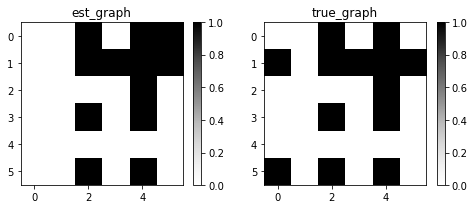

{'fdr': 0.0833, 'tpr': 0.8462, 'fpr': 0.5, 'shd': 2, 'nnz': 12, 'precision': 0.9167, 'recall': 0.8462, 'F1': 0.88, 'gscore': 0.7692}


In [11]:
# plot est_dag and true_dag
GraphDAG(algo.causal_matrix, true_dag)

# calculate accuracy
mm = MetricsDAG(algo.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm.metrics)

In [ ]:
for d in combined_params(consts.DIRECT_LINGAM_VALID_PARAMS):
    print(d)
    print(f"{'=' * 50}")
    try:
        DLG = DirectLiNGAM(**d)
        DLG.learn(data=x)
    except Exception:
        error_params.append(d)
        print(traceback.format_exc())

In [ ]:
# plot est_dag and true_dag
GraphDAG(DLG.causal_matrix, true_dag)

# calculate accuracy
mm = MetricsDAG(DLG.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm.metrics)

In [5]:
d = {'criterion': 'bic', 'method': 'scatter'}
print(d)
print(f"{'=' * 100}")
try:
    GES_1 = GES(**d)
    GES_1.learn(data=x)
except Exception:
    error_params.append(d)
    print(traceback.format_exc())

{'criterion': 'bic', 'method': 'scatter'}


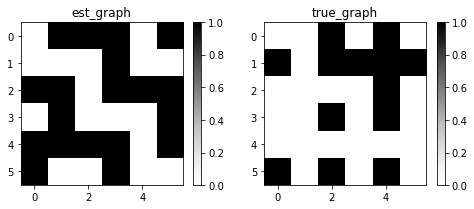

{'fdr': 0.7143, 'tpr': 0.3077, 'fpr': 5.0, 'shd': 11, 'nnz': 14, 'precision': 0.2105, 'recall': 0.3077, 'F1': 0.25, 'gscore': 0.0}


In [6]:
# plot est_dag and true_dag
GraphDAG(GES_1.causal_matrix, true_dag)

# calculate accuracy
mm = MetricsDAG(GES_1.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm)

In [5]:
d = {'criterion': 'bic', 'method': 'r2'}
print(d)
print(f"{'=' * 100}")
try:
    GES_2 = GES(**d)
    GES_2.learn(data=x)
except Exception:
    error_params.append(d)
    print(traceback.format_exc())

{'criterion': 'bic', 'method': 'r2'}


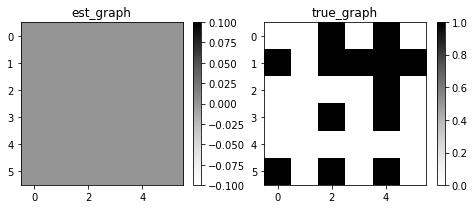

{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 13, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


In [6]:
# plot est_dag and true_dag
GraphDAG(GES_2.causal_matrix, true_dag)

# calculate accuracy
mm = MetricsDAG(GES_2.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm)

In [20]:
d = {'criterion': 'bdeu'}
print(d)
print(f"{'=' * 100}")
try:
    GES_3 = GES(**d)
    GES_3.learn(data=x)
except Exception:
    error_params.append(d)
    print(traceback.format_exc())

{'criterion': 'bdeu'}


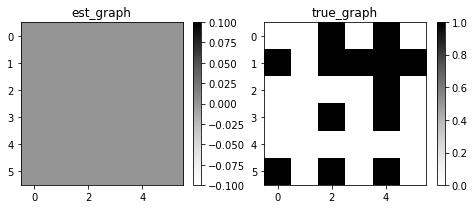

{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 13, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


In [21]:
# plot est_dag and true_dag
GraphDAG(GES_3.causal_matrix, true_dag)

# calculate accuracy
mm = MetricsDAG(GES_3.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm)

In [7]:
p_golem = add_params()
for d in combined_params(p_golem):
    print(d)
    print(f"{'=' * 100}")
    try:
        golem = GOLEM(**d, num_iter=3)
        golem.learn(data=x)
    except Exception:
        error_params.append(d)
        print(traceback.format_exc())

2023-03-16 17:52:39,800 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/notears/torch/golem.py[line:122] - INFO: GPU is unavailable.
2023-03-16 17:52:39,805 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/notears/torch/golem.py[line:207] - INFO: Started training for 3 iterations.
2023-03-16 17:52:39,933 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/notears/torch/golem.py[line:220] - INFO: [Iter 0] score=36.402, likelihood=36.402, h=0.0e+00


{'device_type': 'cpu'}


In [10]:
golem = GOLEM(device_type='cpu', num_iter=3)
golem.learn(data=x)

2023-03-16 17:59:30,163 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/notears/torch/golem.py[line:122] - INFO: GPU is unavailable.
2023-03-16 17:59:30,167 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/notears/torch/golem.py[line:207] - INFO: Started training for 3 iterations.
2023-03-16 17:59:30,168 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/notears/torch/golem.py[line:220] - INFO: [Iter 0] score=36.402, likelihood=36.402, h=0.0e+00


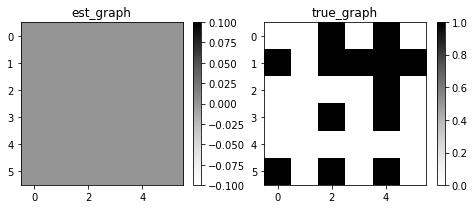

{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 13, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


In [11]:
# plot est_dag and true_dag
GraphDAG(golem.causal_matrix, true_dag)

# calculate accuracy
mm = MetricsDAG(golem.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm)

In [12]:
params = add_params(consts.GRANDAG_VALID_PARAMS)
for d in combined_params(params):
    print(d)
    print(f"{'=' * 100}")
    try:
        grandag = GraNDAG(**d, input_dim=x.shape[1], iterations=3)
        grandag.learn(data=x)
    except Exception:
        error_params.append(d)
        print(traceback.format_exc())

2023-03-16 18:05:29,284 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGaussANM', 'nonlinear': 'leaky-relu', 'optimizer': 'rmsprop', 'norm_prod': 'paths', 'device_type': 'cpu'}


Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 108.82it/s]
2023-03-16 18:05:29,361 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGaussANM', 'nonlinear': 'leaky-relu', 'optimizer': 'rmsprop', 'norm_prod': 'none', 'device_type': 'cpu'}


Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 214.56it/s]
2023-03-16 18:05:29,397 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGaussANM', 'nonlinear': 'leaky-relu', 'optimizer': 'sgd', 'norm_prod': 'paths', 'device_type': 'cpu'}


Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 223.79it/s]
2023-03-16 18:05:29,434 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGaussANM', 'nonlinear': 'leaky-relu', 'optimizer': 'sgd', 'norm_prod': 'none', 'device_type': 'cpu'}


Training Iterations:   0%|          | 0/3 [00:00<?, ?it/s]/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py:422: RuntimeWarning: overflow encountered in cast
  w_adjs[iter, :, :] = w_adj.detach().cpu().numpy().astype(np.float32)
Training Iterations:  33%|███▎      | 1/3 [00:00<00:00, 94.85it/s]
2023-03-16 18:05:29,455 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


Traceback (most recent call last):
  File "/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_86841/3370934198.py", line 7, in <module>
    grandag.learn(data=x)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 343, in learn
    self._to_dag(train_data)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 511, in _to_dag
    A = compute_jacobian_avg(self.model, train_data,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/dag_optimizer.py", line 93, in compute_jacobian_avg
    log_probs = model.compute_log_likelihood(x, weights, biases, extra_params,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 270, in compute_log_likelihood
    conditional = self.get_distribution(density_param)
  Fi

Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 201.34it/s]
2023-03-16 18:05:29,495 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGaussANM', 'nonlinear': 'sigmoid', 'optimizer': 'rmsprop', 'norm_prod': 'none', 'device_type': 'cpu'}


Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 176.42it/s]
2023-03-16 18:05:29,535 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGaussANM', 'nonlinear': 'sigmoid', 'optimizer': 'sgd', 'norm_prod': 'paths', 'device_type': 'cpu'}


Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 243.33it/s]
2023-03-16 18:05:29,568 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGaussANM', 'nonlinear': 'sigmoid', 'optimizer': 'sgd', 'norm_prod': 'none', 'device_type': 'cpu'}


Training Iterations:  33%|███▎      | 1/3 [00:00<00:00, 103.89it/s]
2023-03-16 18:05:29,585 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


Traceback (most recent call last):
  File "/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_86841/3370934198.py", line 7, in <module>
    grandag.learn(data=x)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 343, in learn
    self._to_dag(train_data)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 511, in _to_dag
    A = compute_jacobian_avg(self.model, train_data,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/dag_optimizer.py", line 93, in compute_jacobian_avg
    log_probs = model.compute_log_likelihood(x, weights, biases, extra_params,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 270, in compute_log_likelihood
    conditional = self.get_distribution(density_param)
  Fi

Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 227.48it/s]


{'model_name': 'NonLinGauss', 'nonlinear': 'leaky-relu', 'optimizer': 'rmsprop', 'norm_prod': 'none', 'device_type': 'cpu'}


2023-03-16 18:05:29,659 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.
Training Iterations:   0%|          | 0/3 [00:00<?, ?it/s]
2023-03-16 18:05:29,673 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


Traceback (most recent call last):
  File "/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_86841/3370934198.py", line 7, in <module>
    grandag.learn(data=x)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 340, in learn
    self._train(train_data=train_data, test_data=test_data)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 440, in _train
    loss_val = - torch.mean(self.model.compute_log_likelihood(x,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 270, in compute_log_likelihood
    conditional = self.get_distribution(density_param)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 319, in get_distribution
    return distributions.normal.Normal(dp[0], t

Training Iterations:  33%|███▎      | 1/3 [00:00<00:00, 99.69it/s]
2023-03-16 18:05:29,691 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


Traceback (most recent call last):
  File "/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_86841/3370934198.py", line 7, in <module>
    grandag.learn(data=x)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 343, in learn
    self._to_dag(train_data)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 511, in _to_dag
    A = compute_jacobian_avg(self.model, train_data,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/dag_optimizer.py", line 93, in compute_jacobian_avg
    log_probs = model.compute_log_likelihood(x, weights, biases, extra_params,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 270, in compute_log_likelihood
    conditional = self.get_distribution(density_param)
  Fi

Training Iterations:   0%|          | 0/3 [00:00<?, ?it/s]
2023-03-16 18:05:29,702 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


Traceback (most recent call last):
  File "/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_86841/3370934198.py", line 7, in <module>
    grandag.learn(data=x)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 340, in learn
    self._train(train_data=train_data, test_data=test_data)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 440, in _train
    loss_val = - torch.mean(self.model.compute_log_likelihood(x,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 270, in compute_log_likelihood
    conditional = self.get_distribution(density_param)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 319, in get_distribution
    return distributions.normal.Normal(dp[0], t

Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 215.01it/s]
2023-03-16 18:05:29,742 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGauss', 'nonlinear': 'sigmoid', 'optimizer': 'rmsprop', 'norm_prod': 'none', 'device_type': 'cpu'}


Training Iterations:   0%|          | 0/3 [00:00<?, ?it/s]
2023-03-16 18:05:29,761 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


Traceback (most recent call last):
  File "/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_86841/3370934198.py", line 7, in <module>
    grandag.learn(data=x)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 340, in learn
    self._train(train_data=train_data, test_data=test_data)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 440, in _train
    loss_val = - torch.mean(self.model.compute_log_likelihood(x,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 270, in compute_log_likelihood
    conditional = self.get_distribution(density_param)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 319, in get_distribution
    return distributions.normal.Normal(dp[0], t

Training Iterations: 100%|██████████| 3/3 [00:00<00:00, 215.25it/s]
2023-03-16 18:05:29,802 - /Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py[line:271] - INFO: GPU is unavailable.


{'model_name': 'NonLinGauss', 'nonlinear': 'sigmoid', 'optimizer': 'sgd', 'norm_prod': 'none', 'device_type': 'cpu'}


Training Iterations:   0%|          | 0/3 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_86841/3370934198.py", line 7, in <module>
    grandag.learn(data=x)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 340, in learn
    self._train(train_data=train_data, test_data=test_data)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/gran_dag.py", line 440, in _train
    loss_val = - torch.mean(self.model.compute_log_likelihood(x,
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 270, in compute_log_likelihood
    conditional = self.get_distribution(density_param)
  File "/Users/momo/Desktop/CoDiet/code/gCastle/gcastle/tests/../castle/algorithms/gradient/gran_dag/torch/base/base_model.py", line 319, in get_distribution
    return distributions.normal.Normal(dp[0], t

In [13]:
# plot est_dag and true_dag
GraphDAG(grandag.causal_matrix, true_dag)

# calculate accuracy
mm = MetricsDAG(grandag.causal_matrix, true_dag)
print(mm.metrics)
results.append(mm)

TypeError: Input est_dag is not numpy.ndarray!